In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
results_dir = "../data/results/"
sentiment_dir = "../data/evaluationscore/"
canonization_labels_dir = "../data/labels/"
lang = "ger"

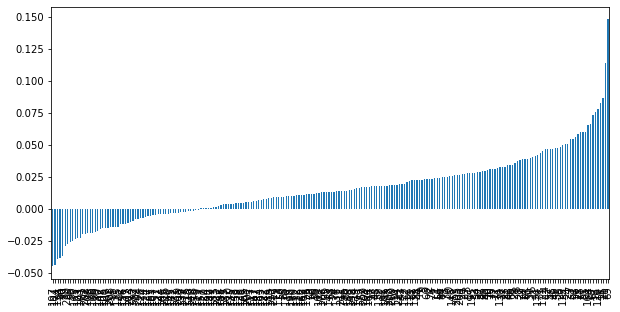

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_sentiment_scores, read_library_scores
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import random
random.seed(9)

labels = read_sentiment_scores(sentiment_dir, canonization_labels_dir, lang)
library_scores = read_library_scores(sentiment_dir, canonization_labels_dir, lang)


In [3]:
labels

,book_name,y,c
0,Alexis_Willibald_Der-falsche-Woldemar_1842,0.025530,3
1,Alexis_Willibald_Ruhe-ist-die-erste-Buergerpfl...,0.023794,3
2,Alexis_Willibald_Cabanis_1830,0.023481,3
3,Alexis_Willibald_Schloss-Avalon_1826,0.027773,3
4,Alexis_Willibald_Walladmor_1824,0.046649,3
...,...,...,...
133,Eichendorff_Joseph_Viel-Laermen-um-Nichts_1832,0.022402,2
142,Fontane_Theodor_Effi-Briest_1895,-0.015735,2
145,Fontane_Theodor_Die-Poppenpuhls_1896,-0.003428,2
178,Moerike_Eduard_Maler-Bolten_1836,0.016478,2


<AxesSubplot:>

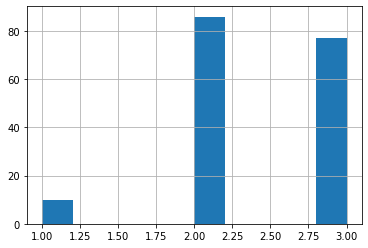

In [4]:
labels["c"].hist()

In [5]:
3 in labels["c"].values

True

173


<AxesSubplot:ylabel='Frequency'>

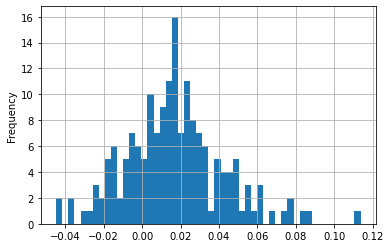

In [6]:
## Labels statistics
print(len(pd.unique(labels["book_name"]))) #197
# 254 labels, 197 different book_names -> 57 second/third... reviews
# 36 book_names with more than 1 label, these 36 book_names have 93 labels
# 93 = 36 first reviews + 57 second/third... reviews
# 6 texts have opposing reviews (13 reviews are opposing)
# 191 texts after aggregating (without opposing reviews)

labels["y"].plot.hist(grid=True, bins=50)

In [7]:
class Regression(object):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95"]) or (dimensionality_reduction is None)
        self._check_class_specific_assertions()
        
        self.language = language
        self.features = features
        self.labels = labels
        self.labels = self._prepare_labels()
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        if self.drop_columns_including:
            self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
            
    def _check_class_specific_assertions(self):
        assert model in ["xgboost", "svr", "lasso"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
    
    def _prepare_labels(self):
        return self.labels.drop(columns="c")

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param, train_X=None, train_y=None, train_book_names=None, task_type=None):
        if self.model == "xgboost":
            if task_type == "binary_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
            elif task_type == "multiclass_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
            elif task_type == "regression":
                is_classification = False
            else:
                raise Exception("Not a valid task_type")
            
            def feval(preds, train_data):
                labels = train_data.get_label()
                if is_classification:
                    labels = labels.astype(int)
                    preds = preds.argmax(axis=1).astype(int)
                    if task_type == "binary_classification":
                        return 'acc', accuracy_score(labels, preds)
                    elif task_type == "multiclass_classification":
                        return 'f1', f1_score(labels, preds, average='macro')
                else:
                    return 'rmse', np.sqrt(mean_squared_error(labels, preds))
            
            if is_classification:
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
            else:
                dtrain = xgboost.DMatrix(train_X, label=train_y)
            results = []
            df = np.hstack((train_book_names, train_X))
            df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(train_X.shape[1])])
            for max_depth in [2, 4, 6, 8]:
                for learning_rate in [None, 0.01, 0.033, 0.1]:
                    for colsample_bytree in [0.33, 0.60, 0.75]:
                        if task_type == "multiclass_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"}
                        elif task_type == "binary_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"}
                        elif task_type == "regression":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1}
                        else:
                            raise Exception("Not a valid task_type")
                        cv_results = xgboost.cv(
                                        params,
                                        dtrain,
                                        num_boost_round=99999,
                                        seed=42,
                                        nfold=5,
                                        folds=self._split_booknames(df, 5, return_indices=True),
                                        feval=feval,
                                        maximize=is_classification, # if classification, maximize f1/acc score.
                                        early_stopping_rounds=10,
                                        verbose_eval=False)

                        if task_type == "binary_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-acc-mean"]
                        elif task_type == "multiclass_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-f1-mean"]
                        elif task_type == "regression":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-rmse-mean"]
                        else:
                            raise Exception("Not a valid task_type")
                        num_boost_round = len(cv_results)
                        if task_type == "multiclass_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"})
                        elif task_type == "binary_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"})
                        elif task_type == "regression":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score})
                        else:
                            raise Exception("Not a valid task_type")
            best_parameters = sorted(results, key=lambda x: x["nested_cv_score"], reverse=is_classification)[0]
            return best_parameters
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "svc":
            return SVC(C=model_param)
        
    def _split_booknames(self, df, nr_splits, return_indices=False):
        """
        Distribute book names over splits.
        All works of an author are in the same split.
        """
        book_names = df["book_name"].unique()
        authors = []
        booknames_authors_mapping = {}

        #Get authors
        for book_name in book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in booknames_authors_mapping:
                booknames_authors_mapping[author].append(book_name)
            else:
                booknames_authors_mapping[author] = []
                booknames_authors_mapping[author].append(book_name)
        #Distribute authors over splits so that each split has approximately the same number of books
        works_per_author = Counter(authors)
        goal_sum = round(len(book_names)/nr_splits)
        tolerance = 0.03
        lower_threshold = goal_sum - round(tolerance*goal_sum)
        upper_threshold = goal_sum + round(tolerance*goal_sum)
        author_splits = []
        popped_dict = {}

        for i in range (0, nr_splits-1):
            works_in_split = 0
            split = []
            curr_author_workcount = 0

            # take values from popped dict first
            if bool(popped_dict):  
                popped = []
                for curr_author, curr_author_workcount in popped_dict.items():
                    # leave item in popped dict if value is too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        continue
                    else:
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                for current_author in popped:
                    del popped_dict[current_author]
            while works_in_split < upper_threshold:
                if bool(works_per_author):
                    curr_author = random.choice(list(works_per_author.keys()))
                    curr_author_workcount = works_per_author.pop(curr_author)
                    # Put values into separate dict if too big
                    if works_in_split + curr_author_workcount > upper_threshold:
                        popped_dict[curr_author] = curr_author_workcount
                    else:
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                else:
                    #ignore upper threshold
                    popped = []
                    for curr_author, curr_author_workcount in popped_dict.items():
                        popped.append(curr_author)
                        split.append(curr_author)
                        works_in_split += curr_author_workcount
                        if works_in_split >= lower_threshold:
                            break
                    for current_author in popped:
                        del popped_dict[current_author]

            author_splits.append(split)
        #Create last split directly from remaining dict
        works_in_last_split = sum(works_per_author.values()) + sum(popped_dict.values())
        split = list(works_per_author.keys()) + list(popped_dict.keys())
        author_splits.append(split)

        if not return_indices:
            #Map author splits to book names
            book_splits = []
            for author_split in author_splits:
                book_split = []
                for author in author_split:
                    book_split.extend(booknames_authors_mapping[author])
                book_splits.append(book_split)
        else:
            book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(book_names))
            book_splits = []
            for author_split in author_splits:
                test_split = []
                for author in author_split:
                    test_split.extend([book_name_idx_mapping[book_name] for book_name in booknames_authors_mapping[author]])
                train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
                book_splits.append((train_split, test_split))
        return book_splits
    
    def _get_pvalue(self, validation_corr_pvalues):
        # Harmonic mean p-value
        denominator = sum([1/x for x in validation_corr_pvalues])
        mean_p_value = len(validation_corr_pvalues)/denominator
        return mean_p_value
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        df = df.merge(right=self.labels, on="book_name", how="inner", validate="many_to_one")
        return df
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = self._split_booknames(df, 5)
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="regression")
                dtrain = xgboost.DMatrix(train_X, label=train_y)
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
                
                print("train preds:", model.predict(xgboost.DMatrix(train_X)))
                print("validation preds:", model.predict(xgboost.DMatrix(validation_X)))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}, ValCorr: {np.round(validation_corr, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        pd.concat(all_validation_books).to_csv(results_dir + "/y-yhat-" + self.language + "-" + ".csv", index=False)
        
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""TrainMSE: {np.round(mean_train_mse, 3)}, TrainRMSE: {np.round(mean_train_rmse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, TrainR2: {np.round(mean_train_r2, 3)}, TrainCorr: {np.round(mean_train_corr, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}, ValCorr: {np.round(mean_validation_corr, 3)}, ValCorrPValue: {np.round(mean_p_value, 3)}""")
            print("\n---------------------------------------------------\n")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.ylim([0,1])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + "-" + self.model + "-" + str(self.dimensionality_reduction) 
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + ".png", 
            dpi=400, bbox_inches="tight")
    
            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value


In [8]:
'''
Classification into reviewed/not reviewed
'''

class TwoclassClassification(Regression):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc", "xgboost"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        
    def _prepare_labels(self):
        labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
        return labels
        
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        agg_labels = self.labels[["book_name"]].drop_duplicates()
        agg_labels["y"] = 1
        df = df.merge(right=agg_labels, on="book_name", how="left", validate="many_to_one")
        df["y"] = df["y"].fillna(value=0)
        #Select books written after year of first review)
        year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
        df = df.loc[year>=min(year)]
        return df
    
    def _get_sample_weights(self, df):
        # Weights for calculating accuracy 
        chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
        chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
        chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
        df = df.merge(right=chunks_per_book, how="left", on="book_name")
        sample_weights = df["chunks_per_book"].tolist()
        return sample_weights
    
    def _aggregate_chunk_predictions(self, df):
        g = df.groupby("book_name")
        
        # Majority vote
        # If one value is more common, assign it to every chunk
        # Therefore, accuracy is either 0 or 1
        # If both values are equally likely, leave them unchanged, and accuracy is 0.5
        def _get_mode_accuracy(group):
            counts = group["yhat"].value_counts()
            if len(counts) == 1:
                mode_acc = counts.index[0]
            else:
                mode_acc = 0.5
            return mode_acc
        mode_accs = g.apply(_get_mode_accuracy).rename("mode_acc").reset_index()
        mode_acc = mode_accs["mode_acc"].mean()
        
        # Average accuracy within book
        book_acc = g.apply(lambda group: accuracy_score(group["y"], group["yhat"])).mean()
        #Accuracy when each chunk is treated as single document
        chunk_acc = accuracy_score(df["y"], df["yhat"])#, sample_weight = self._get_sample_weights(df))
        return {"mode_acc": mode_acc, "book_acc": book_acc, "chunk_acc": chunk_acc}
    
    def _split_booknames_stratified(self, df, nr_splits, return_indices=False):
        label_splits = []
        combined_splits = []
        # Split df into folds for each label individualls
        df_by_labels = df.groupby("y")
        for name, group in df_by_labels:
            split = self._split_booknames(group, 5)
            label_splits.append(split)
        # Combine splits so that one splits combines splits for all labels
        for fold in range(0, nr_splits):
            combined_split = []
            for label in range(0, len(pd.unique(df["y"]))):
                label_split = label_splits[label]
                fold_split = label_split[fold]
                combined_split.extend(fold_split)
            combined_splits.append(combined_split)
        return combined_splits                            
                             
    def run(self):
        train_accs = []
        validation_accs = []
        df = self.df
        df = self._combine_df_labels(df)
        book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
        all_validation_books = []

        for index, split in enumerate(book_names_split_stratified):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            print("class distribution over dfs")
            print(train_df["y"].value_counts())
            print(validation_df["y"].value_counts())
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="binary_classification")
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)

            train_acc = self._aggregate_chunk_predictions(train_books)
            validation_acc = self._aggregate_chunk_predictions(validation_books)
            
            all_validation_books.append(validation_books)
            
            train_accs.append(train_acc)
            validation_accs.append(validation_acc)
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

        train_accs = pd.DataFrame(train_accs)
        validation_accs = pd.DataFrame(validation_accs)

        mean_train_mode_acc = train_accs["mode_acc"].mean()
        mean_train_book_acc = train_accs["book_acc"].mean()
        mean_train_chunk_acc = train_accs["chunk_acc"].mean()
        mean_validation_mode_acc = validation_accs["mode_acc"].mean()
        mean_validation_book_acc = validation_accs["book_acc"].mean()
        mean_validation_chunk_acc = validation_accs["chunk_acc"].mean()
        print(mean_train_mode_acc, mean_train_book_acc, mean_train_chunk_acc)
        print(mean_validation_mode_acc, mean_validation_book_acc, mean_validation_chunk_acc)

        return mean_train_book_acc, mean_validation_book_acc

In [9]:
# ''' 
# Classification into in library/not in library
# '''

# class LibraryClassification(TwoclassClassification):
#     def _prepare_labels(self):
#         return self.labels

In [10]:
'''
Classification into not reviewed/negative/not classified/positive
'''

class MulticlassClassification(TwoclassClassification):
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

    def _check_class_specific_assertions(self):
        assert model in ["svc", "xgboost"]
        assert features in ["book", "book_and_averaged_chunk"]#, "chunk_and_copied_book", "chunk"]
                
    def _combine_df_labels(self, df):
        #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
        df = df.merge(right=self.labels, on="book_name", how="left", validate="many_to_one")
        df["y"] = df["y"].fillna(value=0)
        #Select books written after year of first review
        year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
        df = df.loc[year>=min(year)]
        return df
    
    def _evaluate_predictions(self, df):
        score = f1_score(df["y"], df["yhat"], average='macro')
        return score
            
        
    def run(self):
        train_f1s = []
        validation_f1s = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
        all_validation_books = []

        for index, split in enumerate(book_names_split_stratified):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            print("class distribution over dfs")
            print(train_df["y"].value_counts())
            print(validation_df["y"].value_counts())
            #print(train_df.loc[train_df["y"]==1])
            print(validation_df.loc[validation_df["y"]==1])
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="multiclass_classification")
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_f1 = self._evaluate_predictions(train_books)
            validation_f1 = self._evaluate_predictions(validation_books)
            all_validation_books.append(validation_books)
            
            train_f1s.append(train_f1)
            validation_f1s.append(validation_f1)
            if self.verbose:
                print(f"Fold: {index+1}, TrainF1: {np.round(train_f1, 3)}, ValF1: {np.round(validation_f1, 3)}")
        
        # Save y and y_pred for examples
        all_validation_books = pd.concat(all_validation_books)
        all_validation_books.to_csv(results_dir + "/valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
        print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
        print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

        mean_train_f1 = statistics.mean(train_f1s)
        mean_validation_f1 = statistics.mean(validation_f1s)
        
        if self.verbose:
            print(f"""TrainF1: {np.round(mean_train_f1, 3)}, ValidationF1: {np.round(mean_validation_f1, 3)}""")
            print("\n---------------------------------------------------\n")
        return mean_train_f1, mean_validation_f1

In [11]:
### Cross-validation

# Feature split
complexity_features = []

# All parameters
models = ["svr", "lasso", "xgboost", "svc"]
model_params = {"svr": [1], "lasso": [1, 4], "xgboost": [None], "svc": [0.1, 1, 10, 100, 1000, 10000]} #
dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', [None]]
features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

# Which parameters to use
regression_params = {"model": ["xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], "features": features}
testing_params = {"model": models[3], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book"]}
twoclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book", "book_and_averaged_chunk", "chunk", "chunk_and_copied_book"]}
multiclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1],
                     "features": ["book", "book_and_averaged_chunk"]}

book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
book_df = drop_default_columns(book_df, drop_default_columns_including)
book_and_averaged_chunk_df = drop_default_columns(book_and_averaged_chunk_df, drop_default_columns_including)
chunk_df = drop_default_columns(chunk_df, drop_default_columns_including)
chunk_and_copied_book_df = drop_default_columns(chunk_and_copied_book_df, drop_default_columns_including)

print(len(book_df.columns), len(book_and_averaged_chunk_df.columns),len(chunk_df.columns),len(chunk_and_copied_book_df.columns),)

len(list(book_and_averaged_chunk_df.columns))

for i in list(book_and_averaged_chunk_df.columns):
    print(i)

In [12]:
'''
Run two-class classification
'''
results = []
param_dict = "twoclass" #"twoclass"
for lang in [lang]:
    if param_dict == "testing":
        param_dir = testing_params
    elif param_dict == "twoclass":
        param_dir = twoclass_params
    elif param_dict == "multiclass":
        param_dir = multiclass_params
    elif param_dict == "full_cv":
        param_dir = full_cv_params
    elif param_dict == "language_specific":
        if lang == "eng":
            param_dir = eng_params
        else: 
            param_dir = ger_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

    for model in [] + param_dir['model']:
        print(model)
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in param_dir["dimensionality_reduction"]:
                for features in param_dir["features"]:
                    for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
                        experiment = TwoclassClassification(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction=dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        mean_train_book_acc, mean_validation_book_acc = experiment.run()
                        print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param, mean_train_book_acc, mean_validation_book_acc)
                        results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_book_acc, mean_validation_book_acc))

results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
"dimensionality_reduction", "model_param", "mean_train_book_acc", "mean_validation_book_acc"])
results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)


svc
Dropped 300 columns.
class distribution over dfs
0.0    301
1.0    139
Name: y, dtype: int64
0.0    73
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    137
Name: y, dtype: int64
0.0    73
1.0    36
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    139
Name: y, dtype: int64
0.0    73
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    137
Name: y, dtype: int64
0.0    73
1.0    36
Name: y, dtype: int64
class distribution over dfs
0.0    292
1.0    140
Name: y, dtype: int64
0.0    82
1.0    33
Name: y, dtype: int64
[[374   0]
 [173   0]]
Predicted  0.0  All
True               
0.0        374  374
1.0        173  173
All        547  547
0.0 0.6837073935704073 0.6837073935704073
0.0 0.6833958001707369 0.6833958001707369
ger svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 0.1 0.6837073935704073 0.6833958001707369
Dropped 300 columns.
class distribution over dfs
0.0 

[[6792    0]
 [3725    0]]
Predicted    0.0    All
True                   
0.0         6792   6792
1.0         3725   3725
All        10517  10517
0.0 0.6837255417323754 0.646475145577119
0.0 0.6836709670227807 0.655202872023552
ger svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 0.1 0.6837255417323754 0.6836709670227807
Dropped 868 columns.
class distribution over dfs
0.0    4990
1.0    3245
Name: y, dtype: int64
0.0    1802
1.0     480
Name: y, dtype: int64
class distribution over dfs
0.0    5735
1.0    2836
Name: y, dtype: int64
0.0    1057
1.0     889
Name: y, dtype: int64
class distribution over dfs
0.0    4895
1.0    2589
Name: y, dtype: int64
0.0    1897
1.0    1136
Name: y, dtype: int64
class distribution over dfs
0.0    5473
1.0    3121
Name: y, dtype: int64
0.0    1319
1.0     604
Name: y, dtype: int64
class distribution over dfs
0.0    6075
1.0    3109
Name: y, dtype: int64
0.0    717
1.0    616
Name: y, dtype: int64
[[6792

class distribution over dfs
0.0    299
1.0    137
Name: y, dtype: int64
0.0    75
1.0    36
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    139
Name: y, dtype: int64
0.0    73
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    139
Name: y, dtype: int64
0.0    73
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    296
1.0    138
Name: y, dtype: int64
0.0    78
1.0    35
Name: y, dtype: int64
[[374   0]
 [173   0]]
Predicted  0.0  All
True               
0.0        374  374
1.0        173  173
All        547  547
0.0 0.6837275372583298 0.6837275372583298
0.0 0.6837001076410326 0.6837001076410326
ger svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1 0.6837275372583298 0.6837001076410326
Dropped 377 columns.
class distribution over dfs
0.0    301
1.0    137
Name: y, dtype: int64
0.0    73
1.0    36
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    139
Nam

[[6792    0]
 [3725    0]]
Predicted    0.0    All
True                   
0.0         6792   6792
1.0         3725   3725
All        10517  10517
0.0 0.6837282707237763 0.645548759233785
0.0 0.6837111066777533 0.643344966169535
ger svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1 0.6837282707237763 0.6837111066777533
Dropped 868 columns.
class distribution over dfs
0.0    5504
1.0    3140
Name: y, dtype: int64
0.0    1288
1.0     585
Name: y, dtype: int64
class distribution over dfs
0.0    5723
1.0    2602
Name: y, dtype: int64
1.0    1123
0.0    1069
Name: y, dtype: int64
class distribution over dfs
0.0    4878
1.0    3020
Name: y, dtype: int64
0.0    1914
1.0     705
Name: y, dtype: int64
class distribution over dfs
0.0    5196
1.0    3194
Name: y, dtype: int64
0.0    1596
1.0     531
Name: y, dtype: int64
class distribution over dfs
0.0    5867
1.0    2944
Name: y, dtype: int64
0.0    925
1.0    781
Name: y, dtype: int64
[[

class distribution over dfs
0.0    299
1.0    138
Name: y, dtype: int64
0.0    75
1.0    35
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    139
Name: y, dtype: int64
0.0    73
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    138
Name: y, dtype: int64
0.0    73
1.0    35
Name: y, dtype: int64
class distribution over dfs
0.0    295
1.0    138
Name: y, dtype: int64
0.0    79
1.0    35
Name: y, dtype: int64
[[374   0]
 [173   0]]
Predicted  0.0  All
True               
0.0        374  374
1.0        173  173
All        547  547
0.0 0.6837230478172133 0.6837230478172133
0.0 0.68363094794477 0.68363094794477
ger svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= 10 0.6837230478172133 0.68363094794477
Dropped 377 columns.
class distribution over dfs
0.0    301
1.0    138
Name: y, dtype: int64
0.0    73
1.0    35
Name: y, dtype: int64
class distribution over dfs
0.0    299
1.0    138
Name: y

[[6785    7]
 [3725    0]]
Predicted    0.0  1.0    All
True                        
0.0         6785    7   6792
1.0         3725    0   3725
All        10510    7  10517
0.001366742596810934 0.6835197187901537 0.6457709764099139
0.0018518518518518517 0.6829816288951346 0.6415391576900092
ger svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= 10 0.6835197187901537 0.6829816288951346
Dropped 868 columns.
class distribution over dfs
0.0    5139
1.0    3102
Name: y, dtype: int64
0.0    1653
1.0     623
Name: y, dtype: int64
class distribution over dfs
0.0    5566
1.0    2623
Name: y, dtype: int64
0.0    1226
1.0    1102
Name: y, dtype: int64
class distribution over dfs
0.0    6184
1.0    3225
Name: y, dtype: int64
0.0    608
1.0    500
Name: y, dtype: int64
class distribution over dfs
0.0    4771
1.0    3001
Name: y, dtype: int64
0.0    2021
1.0     724
Name: y, dtype: int64
class distribution over dfs
0.0    5508
1.0    2949
Name: 

class distribution over dfs
0.0    299
1.0    139
Name: y, dtype: int64
0.0    75
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    139
Name: y, dtype: int64
0.0    73
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    299
1.0    139
Name: y, dtype: int64
0.0    75
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    297
1.0    136
Name: y, dtype: int64
0.0    77
1.0    37
Name: y, dtype: int64
[[374   0]
 [173   0]]
Predicted  0.0  All
True               
0.0        374  374
1.0        173  173
All        547  547
0.0 0.6837342502668202 0.6837342502668202
0.0 0.683802712264289 0.683802712264289
ger svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 100 0.6837342502668202 0.683802712264289
Dropped 1168 columns.
class distribution over dfs
0.0    301
1.0    138
Name: y, dtype: int64
0.0    73
1.0    35
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    

class distribution over dfs
0.0    5588
1.0    3168
Name: y, dtype: int64
0.0    1204
1.0     557
Name: y, dtype: int64
class distribution over dfs
0.0    4515
1.0    2811
Name: y, dtype: int64
0.0    2277
1.0     914
Name: y, dtype: int64
[[6788    4]
 [3725    0]]
Predicted    0.0  1.0    All
True                        
0.0         6788    4   6792
1.0         3725    0   3725
All        10513    4  10517
0.0006944444444444444 0.6833637053910403 0.6451691599980889
0.0017391304347826088 0.683410600955358 0.6404785839300832
ger svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 100 0.6833637053910403 0.683410600955358
Dropped 1168 columns.
class distribution over dfs
0.0    4663
1.0    3193
Name: y, dtype: int64
0.0    2129
1.0     532
Name: y, dtype: int64
class distribution over dfs
0.0    5507
1.0    3054
Name: y, dtype: int64
0.0    1285
1.0     671
Name: y, dtype: int64
class distribution over dfs
0.0    5770
1.0    27

class distribution over dfs
0.0    301
1.0    139
Name: y, dtype: int64
0.0    73
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    300
1.0    139
Name: y, dtype: int64
0.0    74
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    296
1.0    136
Name: y, dtype: int64
0.0    78
1.0    37
Name: y, dtype: int64
[[347  27]
 [159  14]]
Predicted  0.0  1.0  All
True                    
0.0        347   27  374
1.0        159   14  173
All        506   41  547
0.06690420603829035 0.7167114420223916 0.7167114420223916
0.07456597746455304 0.6605375271151471 0.6605375271151471
ger svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 1000 0.7167114420223916 0.6605375271151471
Dropped 1168 columns.
class distribution over dfs
0.0    299
1.0    139
Name: y, dtype: int64
0.0    75
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    299
1.0    137
Name: y, dtype: int64
0.0    75
1.0    36
Name: y

class distribution over dfs
0.0    5755
1.0    3015
Name: y, dtype: int64
0.0    1037
1.0     710
Name: y, dtype: int64
class distribution over dfs
0.0    4832
1.0    3286
Name: y, dtype: int64
0.0    1960
1.0     439
Name: y, dtype: int64
[[6778   14]
 [3725    0]]
Predicted    0.0  1.0    All
True                        
0.0         6778   14   6792
1.0         3725    0   3725
All        10503   14  10517
0.0015909090909090907 0.6832425875626668 0.6455409957735923
0.0037383177570093455 0.6823179734212628 0.637737803897146
ger svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 1000 0.6832425875626668 0.6823179734212628
Dropped 1168 columns.
class distribution over dfs
0.0    5601
1.0    2758
Name: y, dtype: int64
0.0    1191
1.0     967
Name: y, dtype: int64
class distribution over dfs
0.0    5727
1.0    2887
Name: y, dtype: int64
0.0    1065
1.0     838
Name: y, dtype: int64
class distribution over dfs
0.0    5546
1.0    

class distribution over dfs
0.0    301
1.0    138
Name: y, dtype: int64
0.0    73
1.0    35
Name: y, dtype: int64
class distribution over dfs
0.0    298
1.0    139
Name: y, dtype: int64
0.0    76
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    296
1.0    139
Name: y, dtype: int64
0.0    78
1.0    34
Name: y, dtype: int64
[[333  41]
 [138  35]]
Predicted  0.0  1.0  All
True                    
0.0        333   41  374
1.0        138   35  173
All        471   76  547
0.13577597491322022 0.7472904808453966 0.7472904808453966
0.13852637411048624 0.6729197291113179 0.6729197291113179
ger svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 10000 0.7472904808453966 0.6729197291113179
Dropped 1168 columns.
class distribution over dfs
0.0    300
1.0    139
Name: y, dtype: int64
0.0    74
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    139
Name: y, dtype: int64
0.0    73
1.0    34
Name: 

class distribution over dfs
0.0    5874
1.0    2902
Name: y, dtype: int64
0.0    918
1.0    823
Name: y, dtype: int64
class distribution over dfs
0.0    5129
1.0    3180
Name: y, dtype: int64
0.0    1663
1.0     545
Name: y, dtype: int64
[[6759   33]
 [3721    4]]
Predicted    0.0  1.0    All
True                        
0.0         6759   33   6792
1.0         3721    4   3725
All        10480   37  10517
0.013495962611007037 0.6845517860509459 0.6472343274268824
0.012778249787595581 0.6814090438778152 0.6338731974901866
ger svc chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 10000 0.6845517860509459 0.6814090438778152
Dropped 1168 columns.
class distribution over dfs
0.0    5029
1.0    2655
Name: y, dtype: int64
0.0    1763
1.0    1070
Name: y, dtype: int64
class distribution over dfs
0.0    5756
1.0    3093
Name: y, dtype: int64
0.0    1036
1.0     632
Name: y, dtype: int64
class distribution over dfs
0.0    5757
1.0    29

class distribution over dfs
0.0    299
1.0    138
Name: y, dtype: int64
0.0    75
1.0    35
Name: y, dtype: int64
class distribution over dfs
0.0    298
1.0    139
Name: y, dtype: int64
0.0    76
1.0    34
Name: y, dtype: int64
[[274 100]
 [124  49]]
Predicted  0.0  1.0  All
True                    
0.0        274  100  374
1.0        124   49  173
All        398  149  547
0.32540211656340856 0.9899584605023307 0.9899584605023307
0.2723460662224274 0.5906069741961022 0.5906069741961022
ger xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None 0.9899584605023307 0.5906069741961022
Dropped 1168 columns.
class distribution over dfs
0.0    299
1.0    139
Name: y, dtype: int64
0.0    75
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    301
1.0    139
Name: y, dtype: int64
0.0    73
1.0    34
Name: y, dtype: int64
class distribution over dfs
0.0    298
1.0    138
Name: y, dtype: int64
0.0    76
1.0    35
Name

class distribution over dfs
0.0    5184
1.0    3102
Name: y, dtype: int64
0.0    1608
1.0     623
Name: y, dtype: int64
class distribution over dfs
0.0    5834
1.0    2604
Name: y, dtype: int64
1.0    1121
0.0     958
Name: y, dtype: int64
class distribution over dfs
0.0    4894
1.0    3151
Name: y, dtype: int64
0.0    1898
1.0     574
Name: y, dtype: int64
[[3522 3270]
 [2130 1595]]
Predicted   0.0   1.0    All
True                        
0.0        3522  3270   6792
1.0        2130  1595   3725
All        5652  4865  10517
0.463041322068103 0.7394589136219147 0.8064874235627737
0.4673655281307873 0.4741063031592271 0.48481200254044515
ger xgboost chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= None 0.7394589136219147 0.4741063031592271
Dropped 1168 columns.
class distribution over dfs
0.0    5613
1.0    2631
Name: y, dtype: int64
0.0    1179
1.0    1094
Name: y, dtype: int64
class distribution over dfs
0.0    5182
1.0    2

In [13]:
'''
Run Multiclass Classification
'''
results = []
param_dict = "multiclass" 
for lang in [lang]:    
    if param_dict == "testing":
        param_dir = testing_params
        model_params = {"svr": [1], "lasso": [1], "xgboost": [None], "svc": [1]} 
    elif param_dict == "multiclass":
        param_dir = multiclass_params
    elif param_dict == "full_cv":
        param_dir = full_cv_params
    elif param_dict == "language_specific":
        if lang == "eng":
            param_dir = eng_params
        else: 
            param_dir = ger_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    #chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    #chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
    for model in [] + param_dir['model']:
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in param_dir["dimensionality_reduction"]:
                for features in param_dir["features"]:
                    for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
                                                #try:
                        print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
                        experiment = MulticlassClassification(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction=dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        mean_train_f1, mean_validation_f1 = experiment.run()
                        results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_f1, mean_validation_f1))

results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
"dimensionality_reduction", "model_param", "mean_train_f1", "mean_validation_f1"])
results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)

ger svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 0.1
Dropped 300 columns.
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                       book_name  \
142        Gotthelf_Jeremias_Uli-der-Knecht_1841   
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
142                        8.315907                       0.71221   
332                        0.000000                       0.00000   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
142                  10.998726                 0.883843   
332                        NaN                      NaN   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
142               0.029412             0.147059               5.227245   
332               0.00000

                               book_name  doc2vec_intra_textual_variance  \
320      Schlegel_Friedrich_Lucinde_1799                        7.404158   
433  Hegelers_Wilhelm_Mutter-Bertha_1893                        5.275145   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
320                      0.958209                  10.352401   
433                      0.453267                   9.009794   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
320                 1.368049               0.142857             0.428571   
433                 0.783623               0.000000             0.000000   

     outlier_score_doc2vec  outlier_score_sbert  \
320               7.391601             0.812023   
433               6.465673             0.615287   

     distance_unigram_minnrdocs_2_maxnrdocs_None  ...  \
320                                     0.033201  ...   
433                                     0.065489  ...   

     pos_trigram_BOS_BO

Fold: 2, TrainF1: 0.203, ValF1: 0.203
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   
530    Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
482                        7.264737                      0.706012   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
482                   9.751256                 0.945219   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
482               0.000000             0.148148               6.330744   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_un

Fold: 2, TrainF1: 0.203, ValF1: 0.203
class distribution over dfs
0.0    300
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                 book_name  doc2vec_intra_textual_variance  \
142  Gotthelf_Jeremias_Uli-der-Knecht_1841                        8.315907   
433    Hegelers_Wilhelm_Mutter-Bertha_1893                        5.275145   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
142                      0.712210                  10.998726   
433                      0.453267                   9.009794   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
142                 0.883843               0.029412             0.147059   
433                 0.783623               0.000000             0.000000   

     outlier_score_doc2vec  outlier_score_sbert  \
142               5.227245             0.394774   
433               6.465673             0.615287

Fold: 5, TrainF1: 0.204, ValF1: 0.198
[[374   0   0   0]
 [ 10   0   0   0]
 [ 86   0   0   0]
 [ 77   0   0   0]]
Predicted  0.0  All
True               
0.0        374  374
1.0         10   10
2.0         86   86
3.0         77   77
All        547  547
TrainF1: 0.203, ValidationF1: 0.203

---------------------------------------------------

ger svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 0.1
Dropped 1168 columns.
class distribution over dfs
0.0    300
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                       book_name  \
93                   Gutzkow_Karl_Seraphine_1837   
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
93                         8.264722                      0.815085   
332                        0.000000               

Fold: 2, TrainF1: 0.203, ValF1: 0.203
class distribution over dfs
0.0    298
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    76
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                       book_name  \
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
472      Przybyszewski_Stanislaw_Totenmesse_1893   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
472                        6.139548                      0.616354   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
472                  10.364912                 0.958747   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332                    0.0                  0.0              13.150402   
472                    0.0                  0.0              10.623343   

     outlier_score_sbert  distance_unigr

Predicted  0.0  All
True               
0.0        374  374
1.0         10   10
2.0         86   86
3.0         77   77
All        547  547
TrainF1: 0.203, ValidationF1: 0.203

---------------------------------------------------

ger svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= 1
Dropped 300 columns.
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                 book_name  doc2vec_intra_textual_variance  \
142  Gotthelf_Jeremias_Uli-der-Knecht_1841                        8.315907   
350  Moritz_Karl-Philipp_Anton-Reiser_1785                        8.873113   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
142                      0.712210                  10.998726   
350                      0.962254                  10.915529   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap

Fold: 1, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    300
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                              book_name  doc2vec_intra_textual_variance  \
93          Gutzkow_Karl_Seraphine_1837                        8.264722   
492  Dohm_Hedwig_Wie-Frauen-werden_1894                        6.796037   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
93                       0.815085                  10.600248   
492                      0.617585                   9.310998   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
93                  0.976482                    0.0             0.500000   
492                 0.785341                    0.0             0.166667   

     outlier_score_doc2vec  outlier_score_sbert  \
93                6.156352             0.556348   
492               7.586464             0.584914   

    

                                        book_name  \
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   
530    Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
482                        7.264737                      0.706012   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
482                   9.751256                 0.945219   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
482               0.000000             0.148148               6.330744   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_unigram_minnrdocs_2_maxnrdocs_None  \
482             0.594265                                     0.023817   
530             0.935299                                     0.101960   

     distan

Fold: 3, TrainF1: 0.203, ValF1: 0.203
class distribution over dfs
0.0    300
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   
530    Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
482                        7.264737                      0.706012   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
482                   9.751256                 0.945219   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
482               0.000000             0.148148               6.330744   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_un

ger svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 1
Dropped 1168 columns.
class distribution over dfs
0.0    300
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
332   Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
482                        7.264737                      0.706012   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
482                   9.751256                 0.945219   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332                    0.0             0.000000              13.150402  

Fold: 2, TrainF1: 0.202, ValF1: 0.206
class distribution over dfs
0.0    301
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                 book_name  doc2vec_intra_textual_variance  \
350  Moritz_Karl-Philipp_Anton-Reiser_1785                        8.873113   
492     Dohm_Hedwig_Wie-Frauen-werden_1894                        6.796037   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
350                      0.962254                  10.915529   
492                      0.617585                   9.310998   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
350                 0.929536                    0.0             0.047619   
492                 0.785341                    0.0             0.166667   

     outlier_score_doc2vec  outlier_score_sbert  \
350              10.670568             0.961998   
492               7.586464             0.584914

                                       book_name  \
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
530   Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332               0.000000                  0.0              13.150402   
530               0.090909                  0.0               8.371417   

     outlier_score_sbert  distance_unigram_minnrdocs_2_maxnrdocs_None  ...  \
332             1.190532                                     0.079947  ...   
530             0.935299                                     0.101960  ...   


Fold: 2, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    297
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    77
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
320             Schlegel_Friedrich_Lucinde_1799   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
320                        7.404158                      0.958209   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
320                  10.352401                 1.368049   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
320               0.142857             0.428571               7.391601   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_unigram_

Fold: 1, TrainF1: 0.203, ValF1: 0.202
class distribution over dfs
0.0    300
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                              book_name  doc2vec_intra_textual_variance  \
93          Gutzkow_Karl_Seraphine_1837                        8.264722   
492  Dohm_Hedwig_Wie-Frauen-werden_1894                        6.796037   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
93                       0.815085                  10.600248   
492                      0.617585                   9.310998   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
93                  0.976482                    0.0             0.500000   
492                 0.785341                    0.0             0.166667   

     outlier_score_doc2vec  outlier_score_sbert  \
93                6.156352             0.556348   
492               7.586464             0.584914   

    

Fold: 2, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                       book_name  \
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
472      Przybyszewski_Stanislaw_Totenmesse_1893   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
472                        6.139548                      0.616354   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
472                  10.364912                 0.958747   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332                    0.0                  0.0              13.150402   
472                    0.0                  0.0              10.623343   

     outlier_score_sbert  distance_unigr

Fold: 4, TrainF1: 0.203, ValF1: 0.205
class distribution over dfs
0.0    298
2.0     67
3.0     60
1.0      8
Name: y, dtype: int64
0.0    76
2.0    19
3.0    17
1.0     2
Name: y, dtype: int64
                                 book_name  doc2vec_intra_textual_variance  \
93             Gutzkow_Karl_Seraphine_1837                        8.264722   
142  Gotthelf_Jeremias_Uli-der-Knecht_1841                        8.315907   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
93                       0.815085                  10.600248   
142                      0.712210                  10.998726   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
93                  0.976482               0.000000             0.500000   
142                 0.883843               0.029412             0.147059   

     outlier_score_doc2vec  outlier_score_sbert  \
93                6.156352             0.556348   
142               5.227245             0.394774

Predicted  0.0  All
True               
0.0        374  374
1.0         10   10
2.0         86   86
3.0         77   77
All        547  547
TrainF1: 0.203, ValidationF1: 0.203

---------------------------------------------------

ger svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->'] None param= 10
Dropped 1168 columns.
class distribution over dfs
0.0    300
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                 book_name  doc2vec_intra_textual_variance  \
93             Gutzkow_Karl_Seraphine_1837                        8.264722   
350  Moritz_Karl-Philipp_Anton-Reiser_1785                        8.873113   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
93                       0.815085                  10.600248   
350                      0.962254                  10.915529   

     sbert_stepwise_distance  ove

class distribution over dfs
0.0    300
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                 book_name  doc2vec_intra_textual_variance  \
142  Gotthelf_Jeremias_Uli-der-Knecht_1841                        8.315907   
350  Moritz_Karl-Philipp_Anton-Reiser_1785                        8.873113   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
142                      0.712210                  10.998726   
350                      0.962254                  10.915529   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
142                 0.883843               0.029412             0.147059   
350                 0.929536               0.000000             0.047619   

     outlier_score_doc2vec  outlier_score_sbert  \
142               5.227245             0.394774   
350              10.670568             0.961998   

     distance_unigram_minnrdocs_2

Fold: 3, TrainF1: 0.203, ValF1: 0.205
class distribution over dfs
0.0    300
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
472  Przybyszewski_Stanislaw_Totenmesse_1893                        6.139548   
492       Dohm_Hedwig_Wie-Frauen-werden_1894                        6.796037   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
472                      0.616354                  10.364912   
492                      0.617585                   9.310998   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
472                 0.958747                    0.0             0.000000   
492                 0.785341                    0.0             0.166667   

     outlier_score_doc2vec  outlier_score_sbert  \
472              10.623343             1.001202   
492               7.586464             0.

Fold: 3, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    301
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                              book_name  doc2vec_intra_textual_variance  \
93          Gutzkow_Karl_Seraphine_1837                        8.264722   
492  Dohm_Hedwig_Wie-Frauen-werden_1894                        6.796037   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
93                       0.815085                  10.600248   
492                      0.617585                   9.310998   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
93                  0.976482                    0.0             0.500000   
492                 0.785341                    0.0             0.166667   

     outlier_score_doc2vec  outlier_score_sbert  \
93                6.156352             0.556348   
492               7.586464             0.584914   

    

Fold: 2, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                               book_name  doc2vec_intra_textual_variance  \
93           Gutzkow_Karl_Seraphine_1837                        8.264722   
433  Hegelers_Wilhelm_Mutter-Bertha_1893                        5.275145   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
93                       0.815085                  10.600248   
433                      0.453267                   9.009794   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
93                  0.976482                    0.0                  0.5   
433                 0.783623                    0.0                  0.0   

     outlier_score_doc2vec  outlier_score_sbert  \
93                6.156352             0.556348   
433               6.465673             0.615287   

 

Fold: 4, TrainF1: 0.203, ValF1: 0.202
class distribution over dfs
0.0    294
2.0     67
3.0     60
1.0      8
Name: y, dtype: int64
0.0    80
2.0    19
3.0    17
1.0     2
Name: y, dtype: int64
                                       book_name  \
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
350        Moritz_Karl-Philipp_Anton-Reiser_1785   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
350                        8.873113                      0.962254   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
350                  10.915529                 0.929536   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332                    0.0             0.000000              13.150402   
350                    0.0             0.047619              10.670568   

     outlier_score_sbert  distance_unigr

Dropped 1168 columns.
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
142       Gotthelf_Jeremias_Uli-der-Knecht_1841   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
142                        8.315907                      0.712210   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
142                  10.998726                 0.883843   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
142               0.029412             0.147059               5.227245   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_unigram_minnrdocs_2_maxn

Dropped 1168 columns.
class distribution over dfs
0.0    301
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                 book_name  doc2vec_intra_textual_variance  \
142  Gotthelf_Jeremias_Uli-der-Knecht_1841                        8.315907   
350  Moritz_Karl-Philipp_Anton-Reiser_1785                        8.873113   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
142                      0.712210                  10.998726   
350                      0.962254                  10.915529   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
142                 0.883843               0.029412             0.147059   
350                 0.929536               0.000000             0.047619   

     outlier_score_doc2vec  outlier_score_sbert  \
142               5.227245             0.394774   
350              10.670568             0.961998   

     distan

Dropped 1245 columns.
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                 book_name  doc2vec_intra_textual_variance  \
142  Gotthelf_Jeremias_Uli-der-Knecht_1841                        8.315907   
433    Hegelers_Wilhelm_Mutter-Bertha_1893                        5.275145   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
142                      0.712210                  10.998726   
433                      0.453267                   9.009794   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
142                 0.883843               0.029412             0.147059   
433                 0.783623               0.000000             0.000000   

     outlier_score_doc2vec  outlier_score_sbert  \
142               5.227245             0.394774   
433               6.465673             0.615287   

     distan

Predicted  0.0  All
True               
0.0        374  374
1.0         10   10
2.0         86   86
3.0         77   77
All        547  547
TrainF1: 0.203, ValidationF1: 0.203

---------------------------------------------------

ger svc book_and_averaged_chunk ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', '->', 'pos'] None param= 100
Dropped 1245 columns.
class distribution over dfs
0.0    299
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    75
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
492          Dohm_Hedwig_Wie-Frauen-werden_1894   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
492                        6.796037                      0.617585   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
492                   9.310998  

0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
350       Moritz_Karl-Philipp_Anton-Reiser_1785   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
350                        8.873113                      0.962254   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
350                  10.915529                 0.929536   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
350               0.000000             0.047619              10.670568   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_unigram_minnrdocs_2_maxnrdocs_None  ...  \
350             0.961998                                     0.100857  ...   
530             0.9

class distribution over dfs
0.0    301
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
472       Przybyszewski_Stanislaw_Totenmesse_1893   
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
472                        6.139548                      0.616354   
482                        7.264737                      0.706012   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
472                  10.364912                 0.958747   
482                   9.751256                 0.945219   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
472                    0.0             0.000000              10.623343   
482                    0.0             0.148148               6.330744   

     outlier_score_sbert  distance_unigram_minnrdocs_2_maxnrdocs_None  ... 

Predicted  0.0  All
True               
0.0        374  374
1.0         10   10
2.0         86   86
3.0         77   77
All        547  547
TrainF1: 0.209, ValidationF1: 0.203

---------------------------------------------------

ger svc book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding', 'pos'] None param= 1000
Dropped 377 columns.
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
320          Schlegel_Friedrich_Lucinde_1799                        7.404158   
472  Przybyszewski_Stanislaw_Totenmesse_1893                        6.139548   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
320                      0.958209                  10.352401   
472                      0.616354                  10.364912   

     sbert_stepwise_distance  overlap_score_

Fold: 1, TrainF1: 0.224, ValF1: 0.205
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                               book_name  doc2vec_intra_textual_variance  \
320      Schlegel_Friedrich_Lucinde_1799                        7.404158   
433  Hegelers_Wilhelm_Mutter-Bertha_1893                        5.275145   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
320                      0.958209                  10.352401   
433                      0.453267                   9.009794   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
320                 1.368049               0.142857             0.428571   
433                 0.783623               0.000000             0.000000   

     outlier_score_doc2vec  outlier_score_sbert  \
320               7.391601             0.812023   
433               6.465673             0.615287   

 

Fold: 1, TrainF1: 0.203, ValF1: 0.203
class distribution over dfs
0.0    299
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    75
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
433         Hegelers_Wilhelm_Mutter-Bertha_1893   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
433                        5.275145                      0.453267   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
433                   9.009794                 0.783623   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
433               0.000000                  0.0               6.465673   
530               0.090909                  0.0               8.371417   

     outlier_score_sbert  distance_unigram_

Fold: 1, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    301
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
350       Moritz_Karl-Philipp_Anton-Reiser_1785   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
350                        8.873113                      0.962254   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
350                  10.915529                 0.929536   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
350               0.000000             0.047619              10.670568   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_unigram_

Fold: 1, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    300
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
472       Przybyszewski_Stanislaw_Totenmesse_1893   
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
472                        6.139548                      0.616354   
482                        7.264737                      0.706012   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
472                  10.364912                 0.958747   
482                   9.751256                 0.945219   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
472                    0.0             0.000000              10.623343   
482                    0.0             0.148148               6.330744   

     outlier_score_sbert  distance_un

Fold: 1, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    300
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
332   Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
482                        7.264737                      0.706012   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
482                   9.751256                 0.945219   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332                    0.0             0.000000              13.150402   
482                    0.0             0.148148               6.330744   

     outlier_score_sbert  distance_un

Fold: 1, TrainF1: 0.369, ValF1: 0.202
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                   book_name  doc2vec_intra_textual_variance  \
350    Moritz_Karl-Philipp_Anton-Reiser_1785                        8.873113   
472  Przybyszewski_Stanislaw_Totenmesse_1893                        6.139548   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
350                      0.962254                  10.915529   
472                      0.616354                  10.364912   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
350                 0.929536                    0.0             0.047619   
472                 0.958747                    0.0             0.000000   

     outlier_score_doc2vec  outlier_score_sbert  \
350              10.670568             0.961998   
472              10.623343             1.

Fold: 1, TrainF1: 0.308, ValF1: 0.196
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                       book_name  \
320              Schlegel_Friedrich_Lucinde_1799   
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
320                        7.404158                      0.958209   
332                        0.000000                      0.000000   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
320                  10.352401                 1.368049   
332                        NaN                      NaN   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
320               0.142857             0.428571               7.391601   
332               0.000000             0.000000              13.150402   

     outlier_score_sbert  distance_unigr

Fold: 1, TrainF1: 0.403, ValF1: 0.226
class distribution over dfs
0.0    297
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    77
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
320             Schlegel_Friedrich_Lucinde_1799   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
320                        7.404158                      0.958209   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
320                  10.352401                 1.368049   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
320               0.142857             0.428571               7.391601   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_unigram_

Fold: 1, TrainF1: 0.359, ValF1: 0.202
class distribution over dfs
0.0    298
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    76
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
350         Moritz_Karl-Philipp_Anton-Reiser_1785   
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
350                        8.873113                      0.962254   
482                        7.264737                      0.706012   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
350                  10.915529                 0.929536   
482                   9.751256                 0.945219   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
350                    0.0             0.047619              10.670568   
482                    0.0             0.148148               6.330744   

     outlier_score_sbert  distance_un

Fold: 1, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    301
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                       book_name  \
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
433          Hegelers_Wilhelm_Mutter-Bertha_1893   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
433                        5.275145                      0.453267   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
433                   9.009794                 0.783623   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332                    0.0                  0.0              13.150402   
433                    0.0                  0.0               6.465673   

     outlier_score_sbert  distance_unigr

Fold: 1, TrainF1: 0.203, ValF1: 0.202
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   
530    Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
482                        7.264737                      0.706012   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
482                   9.751256                 0.945219   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
482               0.000000             0.148148               6.330744   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_un

Fold: 1, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                       book_name  \
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
530   Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332               0.000000                  0.0              13.150402   
530               0.090909                  0.0               8.371417   

     outlier_score_sbert  distance_unigr

Fold: 1, TrainF1: 0.203, ValF1: 0.204
class distribution over dfs
0.0    301
2.0     68
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    18
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
472     Przybyszewski_Stanislaw_Totenmesse_1893   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
472                        6.139548                      0.616354   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
472                  10.364912                 0.958747   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
472               0.000000                  0.0              10.623343   
530               0.090909                  0.0               8.371417   

     outlier_score_sbert  distance_unigram_

Fold: 1, TrainF1: 0.95, ValF1: 0.239
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                 book_name  doc2vec_intra_textual_variance  \
93             Gutzkow_Karl_Seraphine_1837                        8.264722   
350  Moritz_Karl-Philipp_Anton-Reiser_1785                        8.873113   

     sbert_intra_textual_variance  doc2vec_stepwise_distance  \
93                       0.815085                  10.600248   
350                      0.962254                  10.915529   

     sbert_stepwise_distance  overlap_score_doc2vec  overlap_score_sbert  \
93                  0.976482                    0.0             0.500000   
350                 0.929536                    0.0             0.047619   

     outlier_score_doc2vec  outlier_score_sbert  \
93                6.156352             0.556348   
350              10.670568             0.961998 

Fold: 1, TrainF1: 0.979, ValF1: 0.241
class distribution over dfs
0.0    298
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    76
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
492          Dohm_Hedwig_Wie-Frauen-werden_1894   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
492                        6.796037                      0.617585   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
492                   9.310998                 0.785341   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
492               0.000000             0.166667               7.586464   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_unigram_

Fold: 1, TrainF1: 0.836, ValF1: 0.379
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
472     Przybyszewski_Stanislaw_Totenmesse_1893   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
472                        6.139548                      0.616354   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
472                  10.364912                 0.958747   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
472               0.000000                  0.0              10.623343   
530               0.090909                  0.0               8.371417   

     outlier_score_sbert  distance_unigram_

Fold: 1, TrainF1: 0.934, ValF1: 0.316
class distribution over dfs
0.0    300
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                      book_name  \
320             Schlegel_Friedrich_Lucinde_1799   
530  Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
320                        7.404158                      0.958209   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
320                  10.352401                 1.368049   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
320               0.142857             0.428571               7.391601   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_unigram_

Fold: 1, TrainF1: 0.95, ValF1: 0.224
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                       book_name  \
142        Gotthelf_Jeremias_Uli-der-Knecht_1841   
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
142                        8.315907                       0.71221   
332                        0.000000                       0.00000   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
142                  10.998726                 0.883843   
332                        NaN                      NaN   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
142               0.029412             0.147059               5.227245   
332               0.000000             0.000000              13.150402   

     outlier_score_sbert  distance_unigra

Fold: 1, TrainF1: 0.938, ValF1: 0.326
class distribution over dfs
0.0    299
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    75
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                       book_name  \
332  Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
350        Moritz_Karl-Philipp_Anton-Reiser_1785   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
350                        8.873113                      0.962254   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
350                  10.915529                 0.929536   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332                    0.0             0.000000              13.150402   
350                    0.0             0.047619              10.670568   

     outlier_score_sbert  distance_unigr

Fold: 1, TrainF1: 0.967, ValF1: 0.257
class distribution over dfs
0.0    300
2.0     69
3.0     62
1.0      8
Name: y, dtype: int64
0.0    74
2.0    17
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   
530    Holz-Schlaf_Arno-Johannes_Papa-Hamlet_1889   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
482                        7.264737                      0.706012   
530                        8.675669                      0.606698   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
482                   9.751256                 0.945219   
530                  10.381968                 0.760443   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
482               0.000000             0.148148               6.330744   
530               0.090909             0.000000               8.371417   

     outlier_score_sbert  distance_un

Fold: 1, TrainF1: 0.904, ValF1: 0.193
class distribution over dfs
0.0    301
2.0     70
3.0     62
1.0      8
Name: y, dtype: int64
0.0    73
2.0    16
3.0    15
1.0     2
Name: y, dtype: int64
                                        book_name  \
332   Kleist_Heinrich_Das-Erdbeben-von-Chili_1807   
482  Eichendorff_Joseph_Ahnung-und-Gegenwart_1815   

     doc2vec_intra_textual_variance  sbert_intra_textual_variance  \
332                        0.000000                      0.000000   
482                        7.264737                      0.706012   

     doc2vec_stepwise_distance  sbert_stepwise_distance  \
332                        NaN                      NaN   
482                   9.751256                 0.945219   

     overlap_score_doc2vec  overlap_score_sbert  outlier_score_doc2vec  \
332                    0.0             0.000000              13.150402   
482                    0.0             0.148148               6.330744   

     outlier_score_sbert  distance_un

In [14]:
# 378 texts without reviews, 197 different books with reviews, 6 of which have opposing reviews and are left out.
# 378 + 197 - 6 = 569 texts

In [15]:
# '''
# Run Regression
# '''
# results = []
# param_dict = "regression" 
# for lang in [lang]:
#     if param_dict == "regression":
#         param_dir = regression_params
#     if param_dict == "testing":
#         param_dir = testing_params
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

#     for model in param_dir['model']:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
#                         experiment = Regression(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value = experiment.run()
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))
#                         #except Exception as e:
# #                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
# #                             print(e)
# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
# "mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
# "mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
# results_df.to_csv(results_dir + lang + '_' + 'regression_' + param_dict + ".csv", index=False)